In [22]:
%pylab inline
from collections import Counter, defaultdict
import pandas as pd
import glob
import os
import itertools
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from gcca import GCCA

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from ee546_utils import *
#MARKERS = list(Line2D.filled_markers)
MARKERS = ['o',  'x', '^', '*','>', '<', 's',  'H',  '8', 'p', 'h',  'D', 'd', 'P']
TISSUES_SHORT_FORM_MAP = {'lv': 'liver',
                          'skm': 'muscle',
                          'br': 'brain',
                          'ht': 'heart',
                          'kd': 'kidney',
                          'cb': 'cerebellum',
                          'lv': 'liver',
                          'ts': 'testes'
                         }

SPECIES_COMMON_NAME_MAP = {"bos_taurus": "Cow",
                           "rattus_norvegicus": "Rat",
                           "pongo_abelii": "Orangutan",
                           "monodelphis_domestica": "Opossum",
                           "macaca_mulatta": "Rhesus",
                           "pan_troglodytes": "Chimp",
                           "mus_musculus": "Mouse",
                           "homo_sapiens": "Human",
                           "gallus_gallus": "Chicken",
                           "ornithorhynchus_anatinus":  "Platypus",
                           "gorilla_gorilla": "Gorilla",
                           "pan_paniscus": "Bonobo"}

SPECIES_COMMON_NAME_MAP_SHORT = {"btaurus": "Cow",
                                 "rnorvegicus": "Rat",
                                 "pabelii": "Orangutan",
                                 "mdomestica": "Opposum",
                                 "mmulatta": "Rhesus",
                                 "ptroglodytes": "Chimp",
                                 "mmusculus": "Mouse",
                                 "hsapiens": "Human",
                                 "ggallus": "Chicken",
                                 "oanatinus":  "Platypus",
                                 "ggorilla": "Gorrila",
                                 "ppaniscus": "Bonobo"}
def species_short(name):
    return name[0] + name.split('_')[1]


def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict

def do_PCA(X, target_names, ax=None):
    sns.set_context('poster')#, font_scale=1.75)
    sns.set_style('white')
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    
    #ax.set_title('PCA')
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    #fig.tight_layout()
    
    return X_r, fig

def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    
def do_CCA(X, Y, target_names, ax=None):
    
    sns.set_context('poster')#, font_scale=1.7)
    sns.set_style('white')
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8.5))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Tissue',
    #             bbox_to_anchor=(1.04,1), loc="upper left",)
    
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    ax.add_artist(leg)
    #ax.set_title('CCA')
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    #fig.tight_layout()
    #fig.tight_layout()
    return fig

def normalize_df_rowwise(df):
    df_centered = df.sub(df.mean(axis=1), axis=0)
    df_centered = df_centered.div(df_centered.std(axis=1), axis=0)
    return df_centered

def normalize_df_colwise(df):
    df_centered = df.sub(df.mean(axis=0), axis=1)
    df_centered = df_centered.div(df_centered.std(axis=0), axis=1)
    return df_centered

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 01. Read Data

In [3]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


## 03. Read kallisto tables SRP016501

In [6]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP016501-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)               

In [7]:
srp = 'SRP016501'
pairwise_kallisto_counts = {}
pairwise_kallisto_counts_normalized = {}
pairwise_kallisto_counts_normalized_individual = defaultdict(dict)
for species1, species2 in itertools.combinations(srp_species[srp], 2):
    # load counts
    counts1 = kallisto_counts['{}_{}'.format(srp, species1)]
    counts2 = kallisto_counts['{}_{}'.format(srp, species2)]
    
    if species1 ==  'mmusculus':
        species1, species2 = species2, species1
        counts1, counts2 = counts2, counts1
        #cols_to_use = counts1.columns.tolist()
        # Only use these columns in the second dataframe
        #counts2 = counts2.loc[:, cols_to_use]
    if species2 ==  'mmusculus':
        cols_to_use = counts2.columns.tolist()
        # Only use these columns in the second dataframe
        counts1 = counts1.loc[:, cols_to_use]
    print(species1, species2)
    if species2 != 'mmusculus':
        ortho1 = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho1 = ortho1.loc[ortho1['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho1 = ortho1.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
    
        ortho2 = ortho_pairwise['mmusculus_{}'.format(species2)]
        ortho2 = ortho2.loc[ortho2['{}_homolog_orthology_type'.format(species2)]=='ortholog_one2one']
        ortho2 = ortho2.drop(columns=['{}_homolog_orthology_type'.format(species2)]) 
        
        ortho_12 = ortho1.join(ortho2, how='outer').dropna().reset_index(drop=True)\
                    .set_index('{}_homolog_ensembl_gene'.format(species1))
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species2)
        species1_ortho_genes  = ortho_12.index
        species2_ortho_genes  = ortho_12['{}_homolog_ensembl_gene'.format(species2)]
        
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts1_trimmed.index
        reduced_set = ortho_12.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts2_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set.index]
        counts2_trimmed = counts2_trimmed.loc[reduced_set[species2_lookup_col]]
        del ortho_12
        del reduced_set
        del ortho1
        del ortho2
    else:
        
        ortho = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho = ortho.loc[ortho['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho = ortho.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species1)

        species1_ortho_genes  = ortho['{}_homolog_ensembl_gene'.format(species1)]
        species2_ortho_genes  = ortho.index.tolist()
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts2_trimmed.index
        reduced_set = ortho.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts1_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set[species2_lookup_col]]
        counts2_trimmed = counts2_trimmed.loc[reduced_set.index]                        
        del ortho
    if len(counts1.columns)!= len(counts2.columns):
        print('Skipping {}, {}'.format(species1, species2))
        continue
    assert (counts1.columns == counts2.columns).all()
    
    counts1_trimmed.columns =  ['{}_{}'.format(species1, x) for x in counts1_trimmed.columns]
    counts2_trimmed.columns =  ['{}_{}'.format(species2, x) for x in counts2_trimmed.columns]
    
    del counts1
    del counts2
    counts2_trimmed.index = counts1_trimmed.index.tolist()
    counts_concat = pd.concat([counts1_trimmed.T, counts2_trimmed.T], ignore_index=False)
    pairwise_kallisto_counts['{}_{}'.format(species1, species2)] = counts_concat
    
    counts_concat_centered = counts_concat.sub(counts_concat.mean(axis=1), axis=0)
    counts_concat_centered = counts_concat_centered.div(counts_concat_centered.std(axis=1), axis=0)
    
    pairwise_kallisto_counts_normalized['{}_{}'.format(species1, species2)] = counts_concat_centered
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species1] = counts_concat_centered.iloc[:len(counts1_trimmed.T.index),]
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species2] = counts_concat_centered.iloc[len(counts1_trimmed.T.index):,]

ggallus mmulatta


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:38: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


ggallus btaurus
ggallus mmusculus
ggallus rnorvegicus


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:59: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:60: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


mmulatta btaurus
mmulatta mmusculus
mmulatta rnorvegicus
btaurus mmusculus
btaurus rnorvegicus
rnorvegicus mmusculus


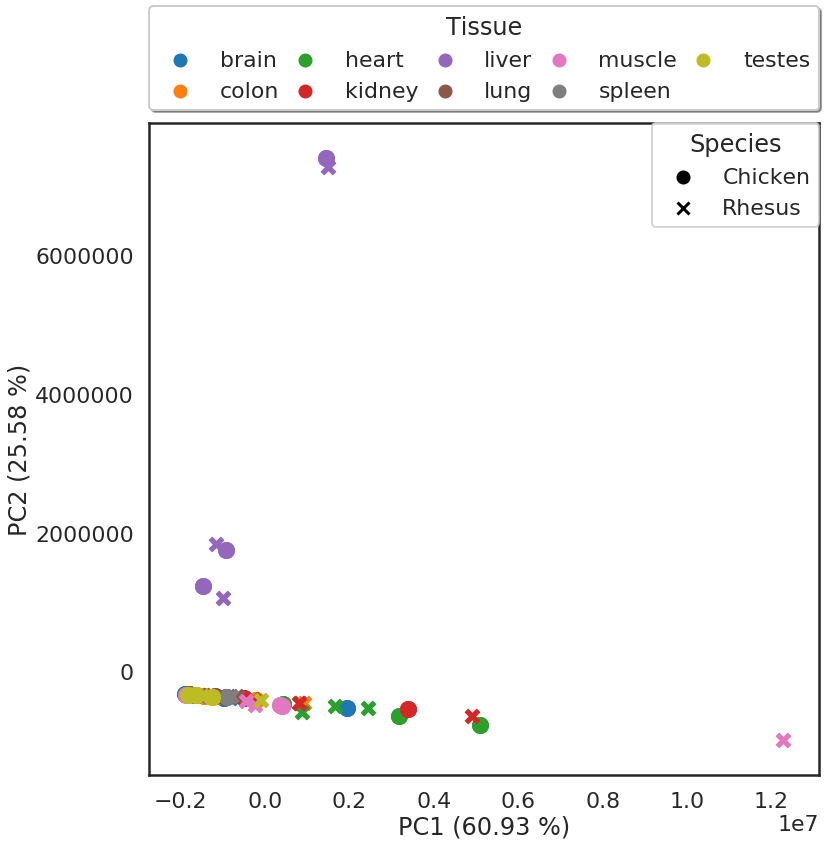

In [6]:
X = pairwise_kallisto_counts['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts['ggallus_mmulatta'].index
X_r, fig = do_PCA(X, target_names)

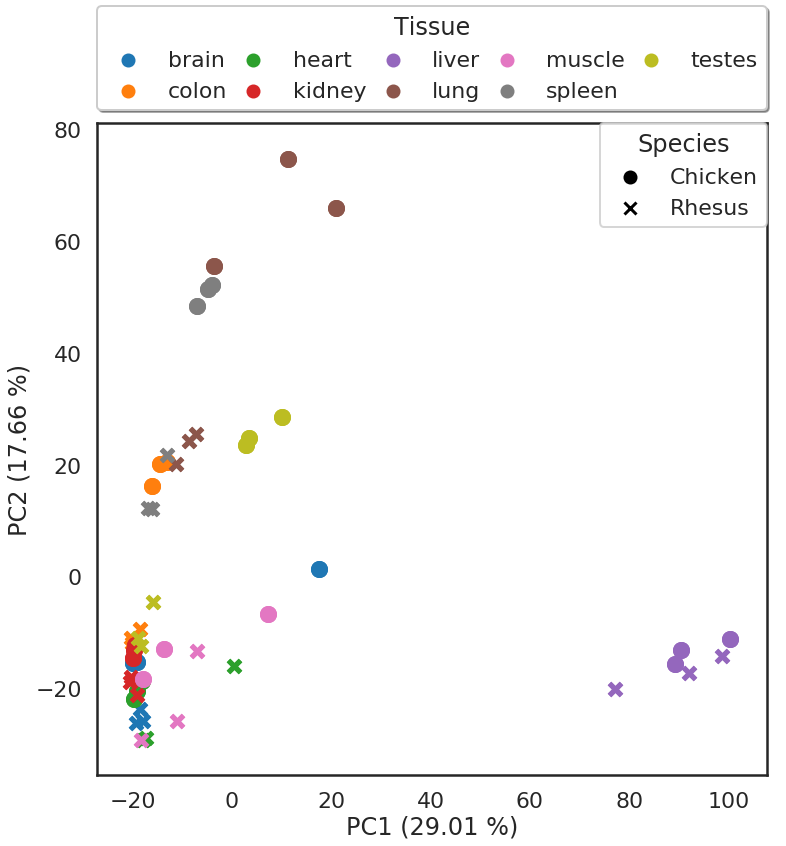

In [7]:
X = pairwise_kallisto_counts_normalized['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts_normalized['ggallus_mmulatta'].index
X_r, fig = do_PCA(X, target_names)

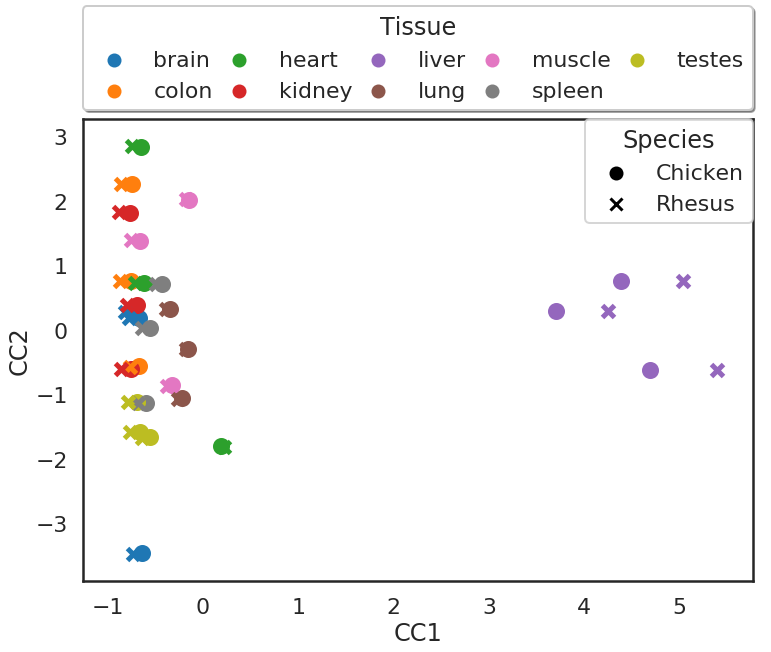

In [8]:
X = pairwise_kallisto_counts_normalized_individual['ggallus_mmulatta']['ggallus']

X = X_r[:X.shape[0],]
Y = X_r[X.shape[0]:,]
fig = do_CCA(X, Y, target_names)


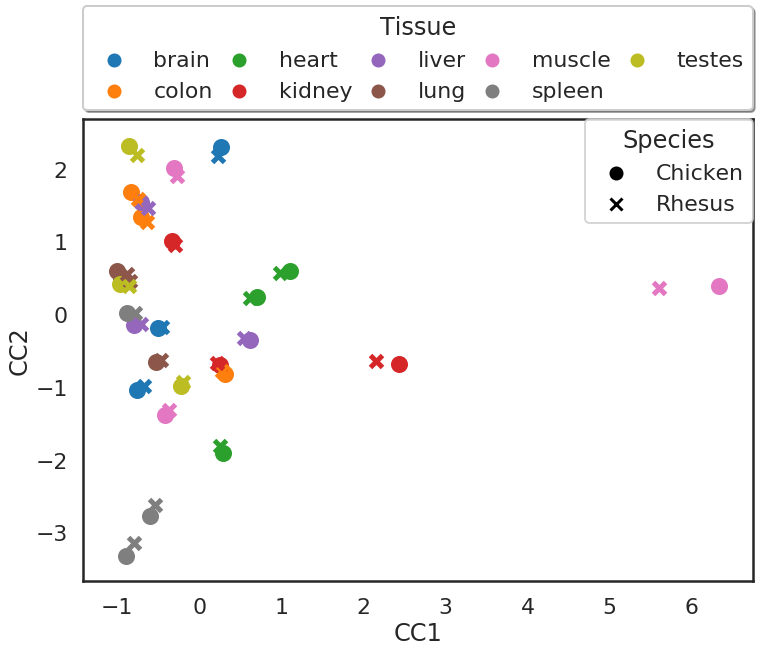

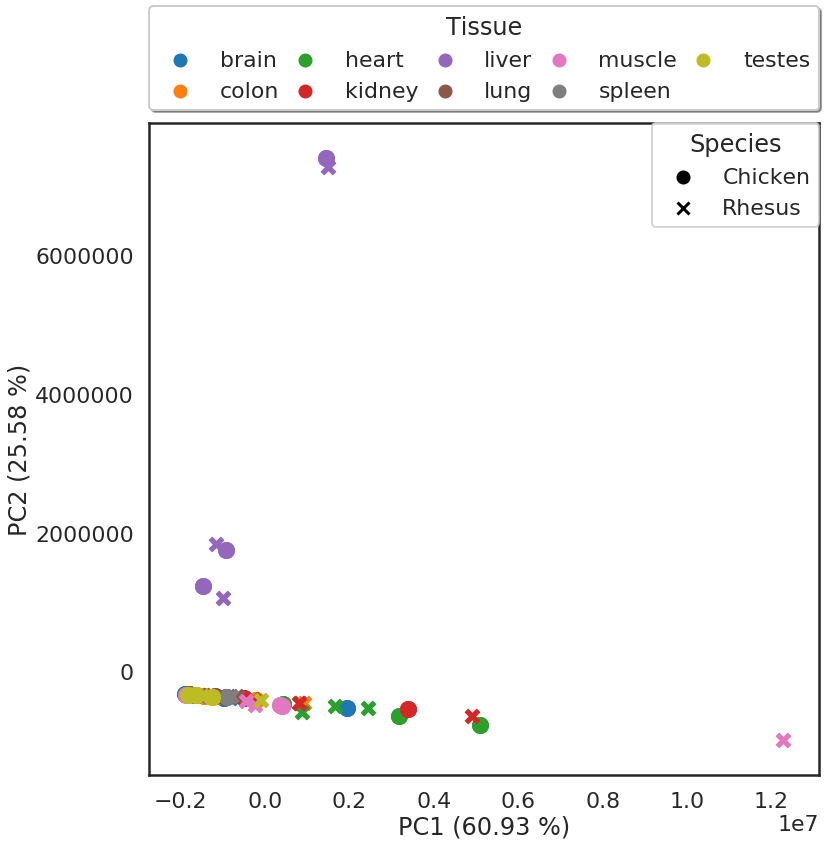

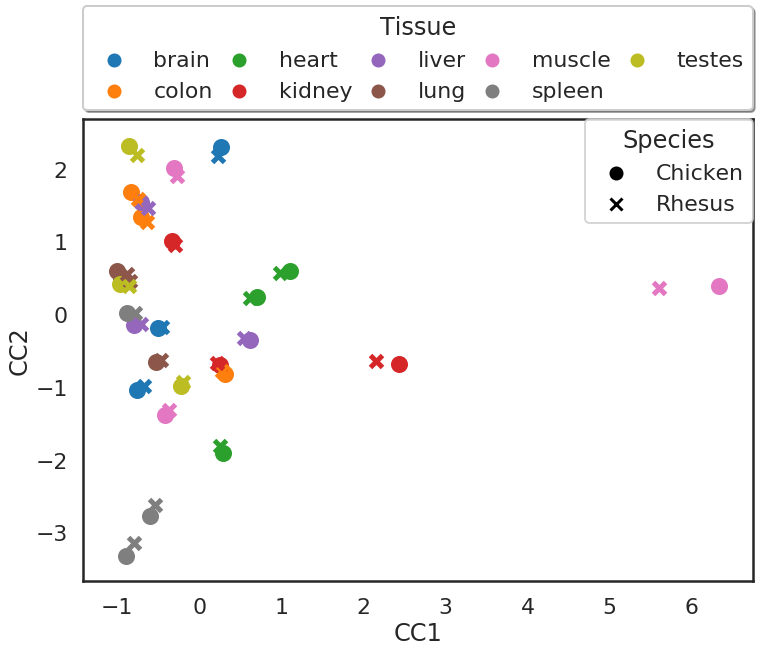

In [9]:
X = pairwise_kallisto_counts['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts['ggallus_mmulatta'].index
X_r, fig = do_PCA(X, target_names) 

X = pairwise_kallisto_counts_normalized_individual['ggallus_mmulatta']['ggallus']

X = X_r[:X.shape[0],]
Y = X_r[X.shape[0]:,]
do_CCA(X, Y, target_names)


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


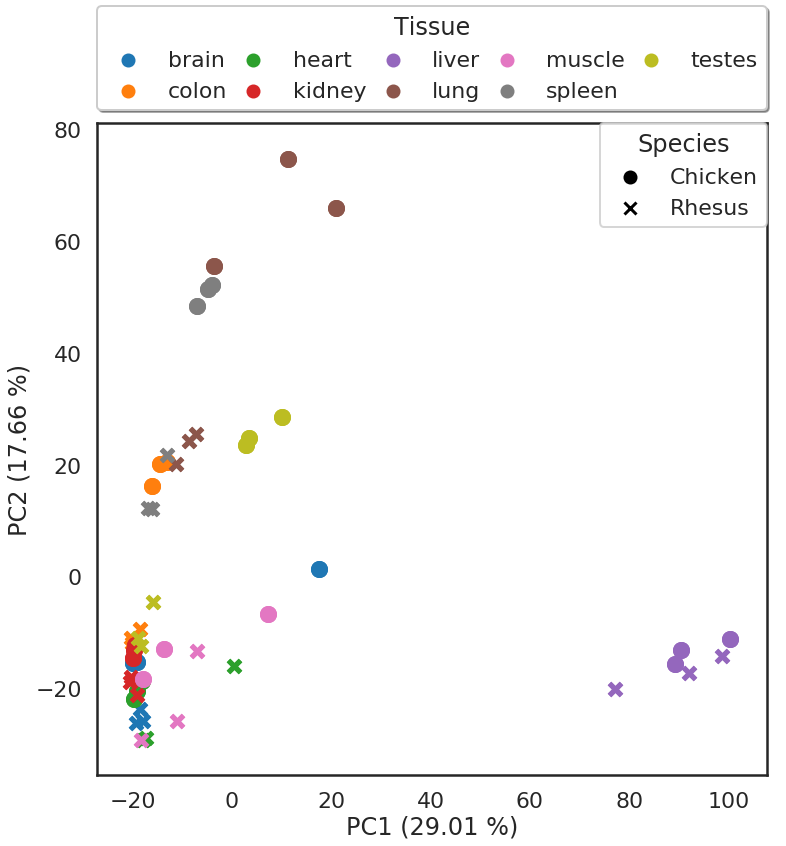

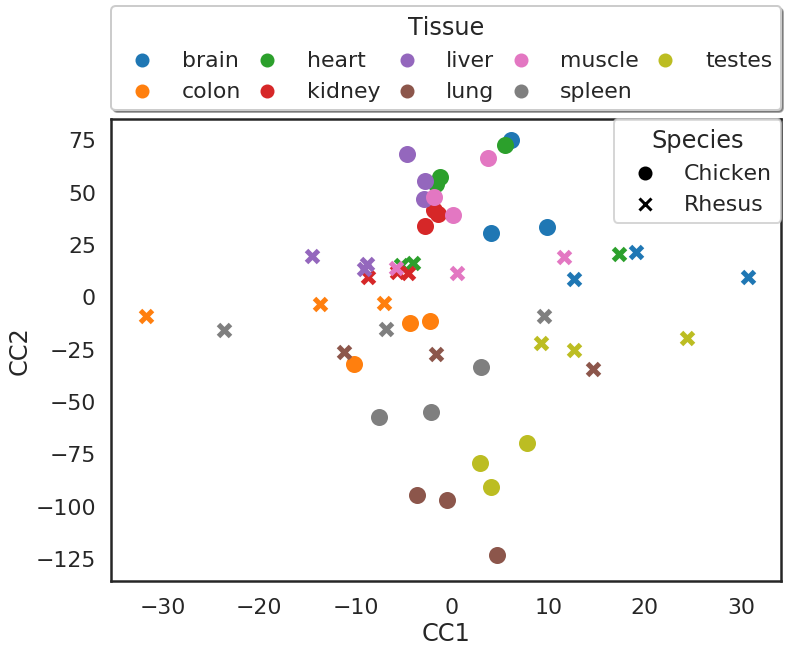

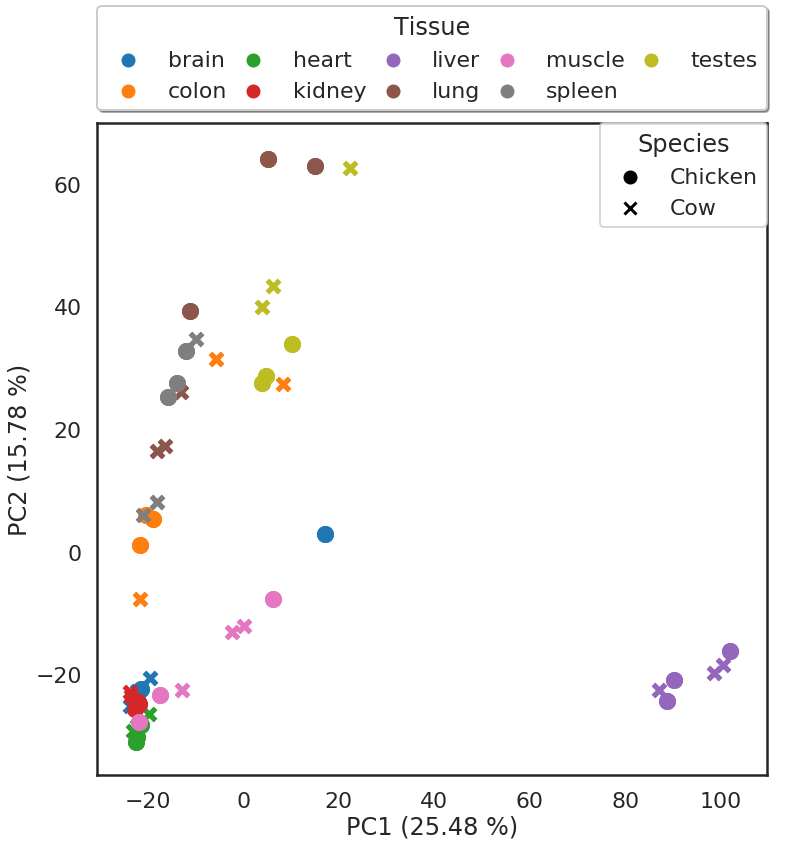

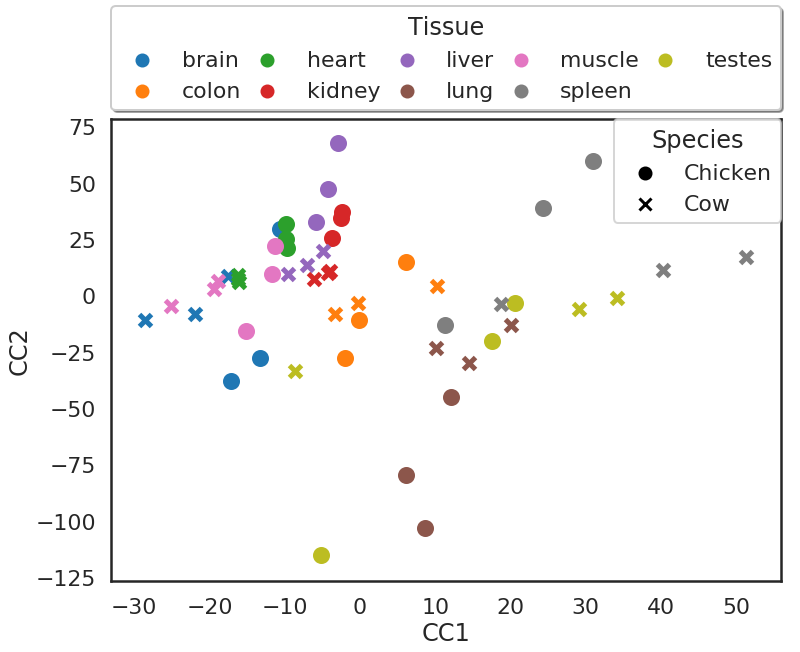

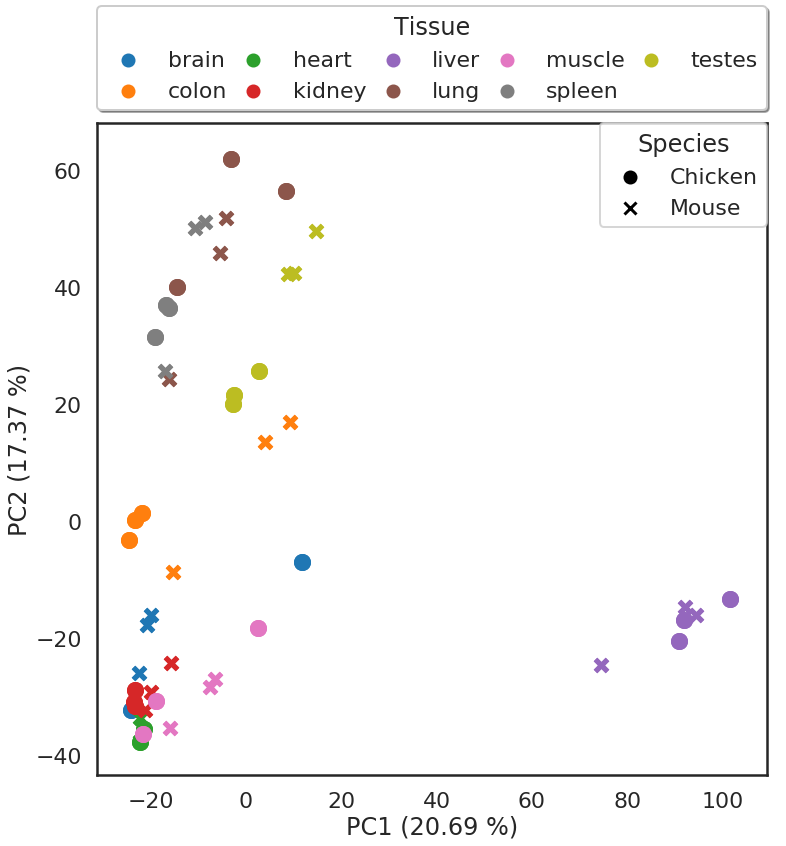

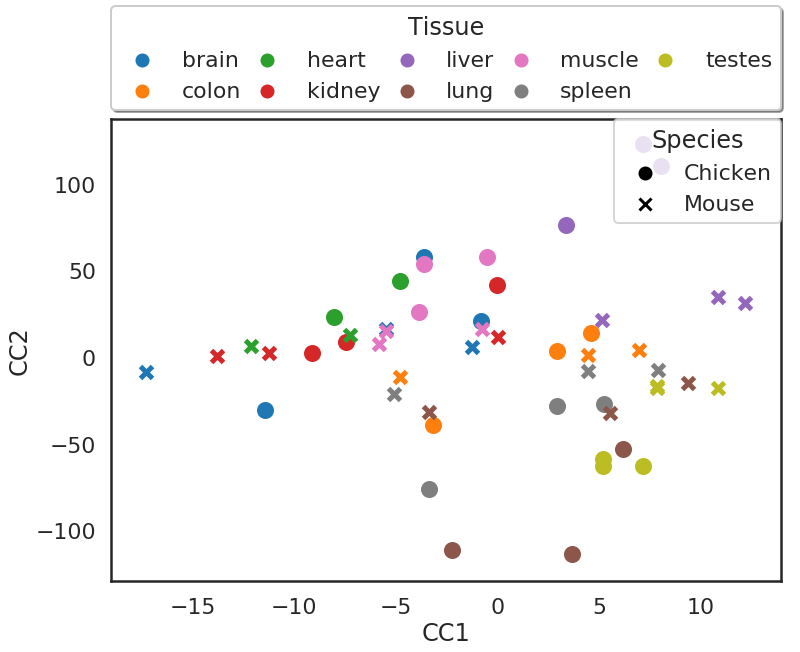

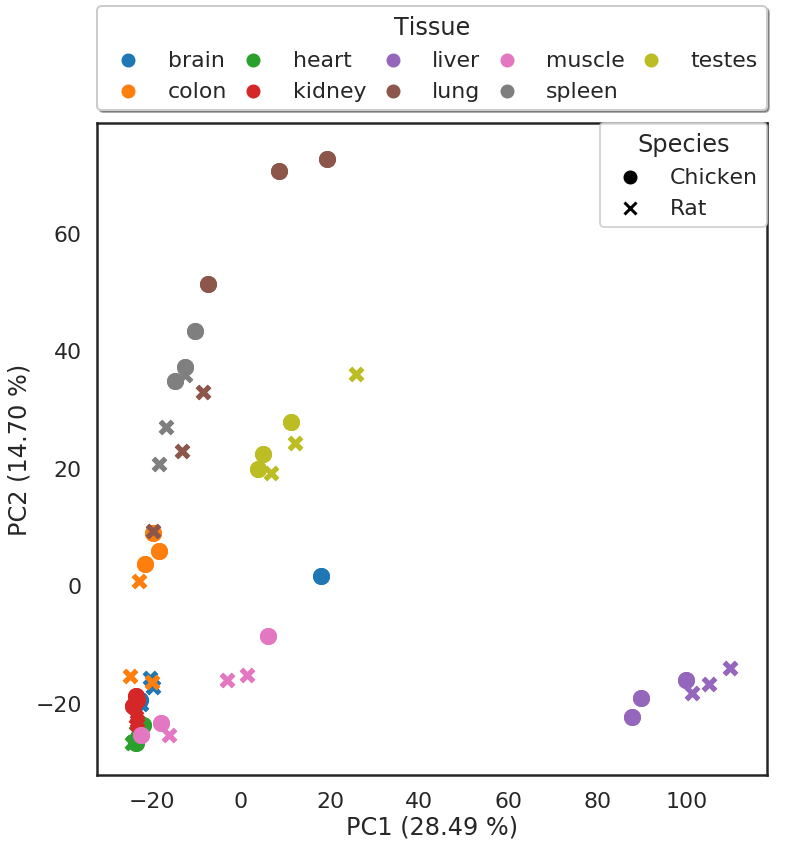

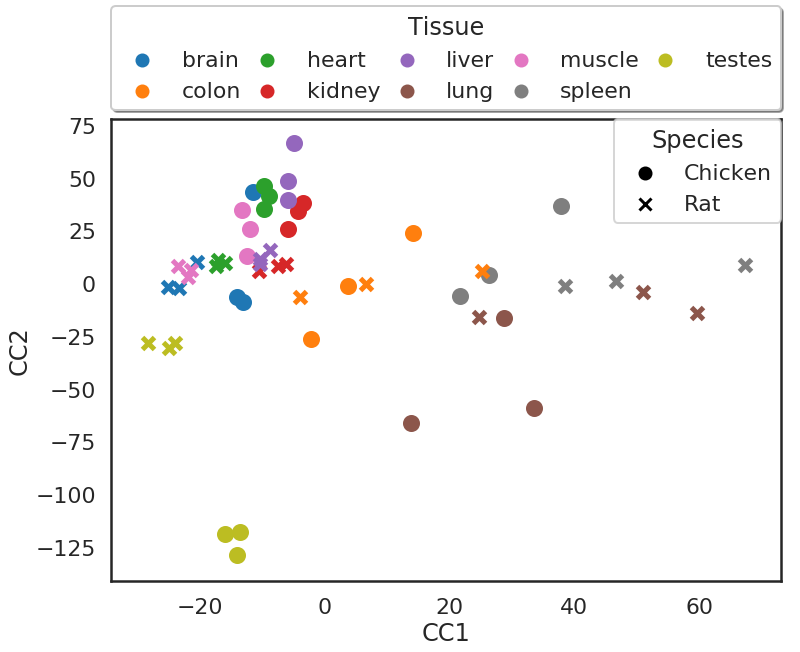

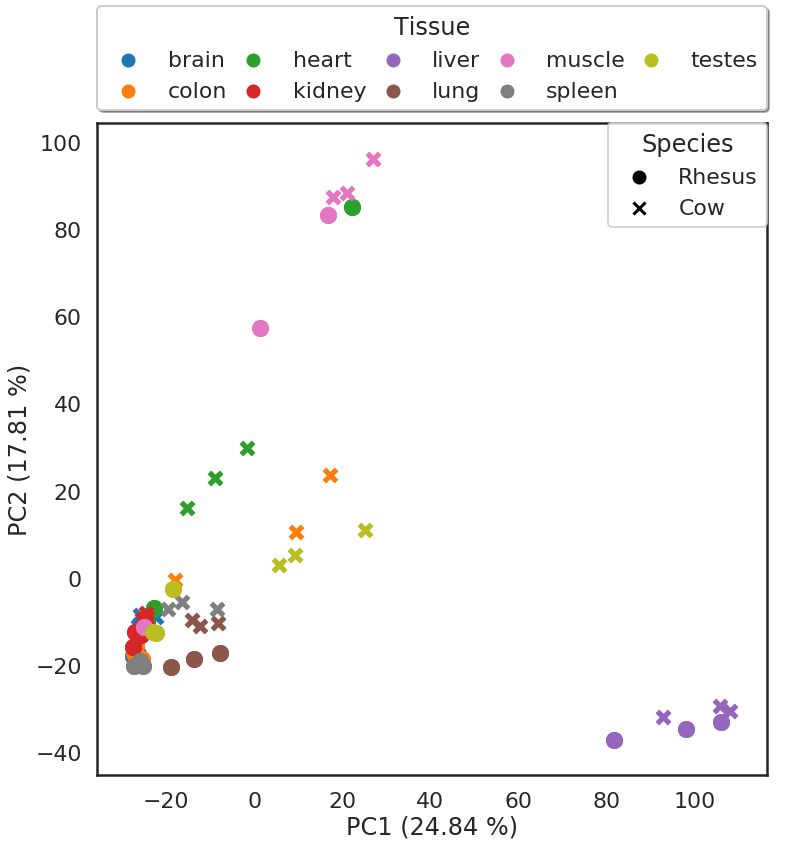

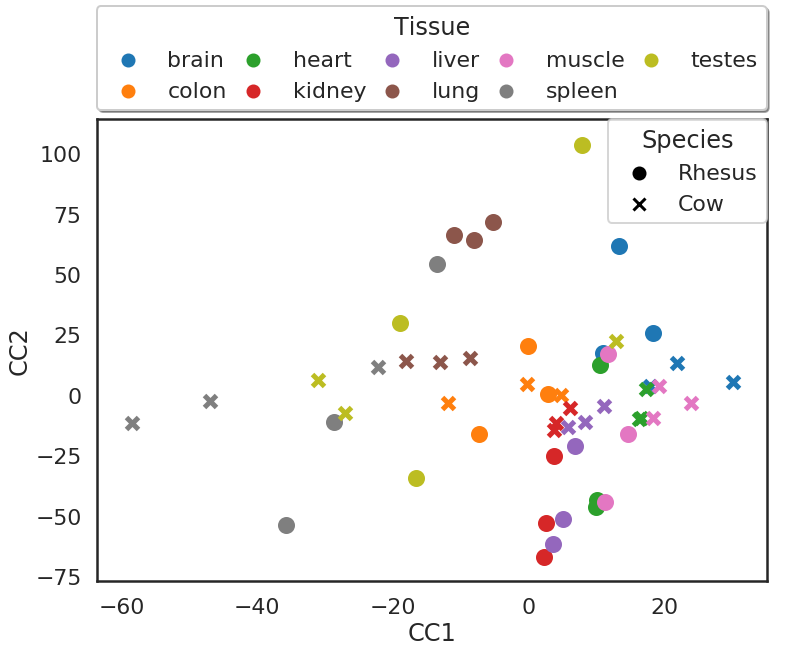

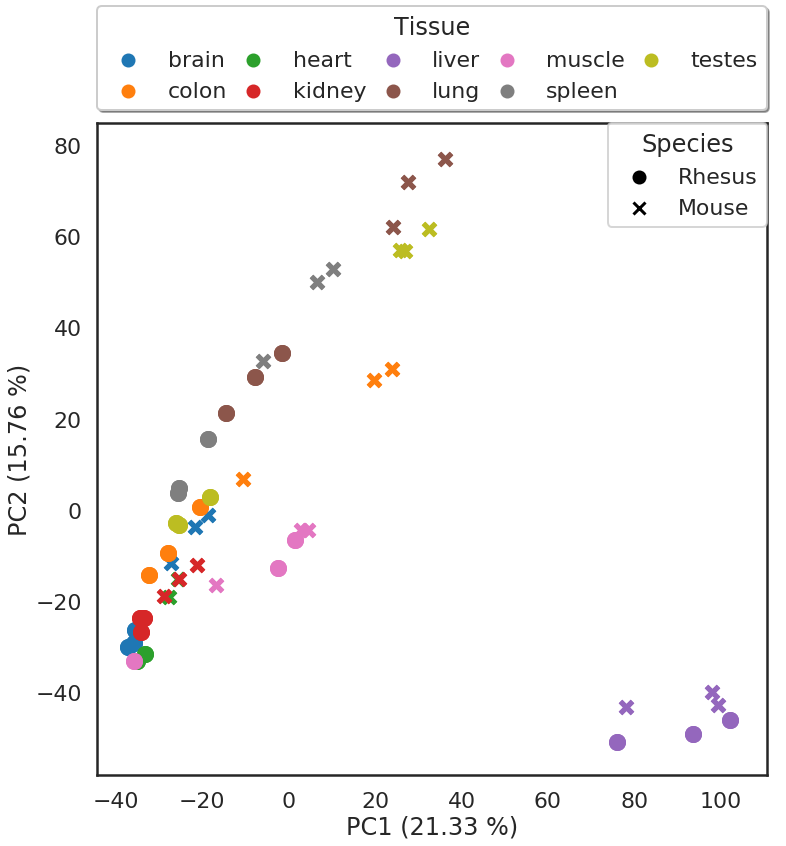

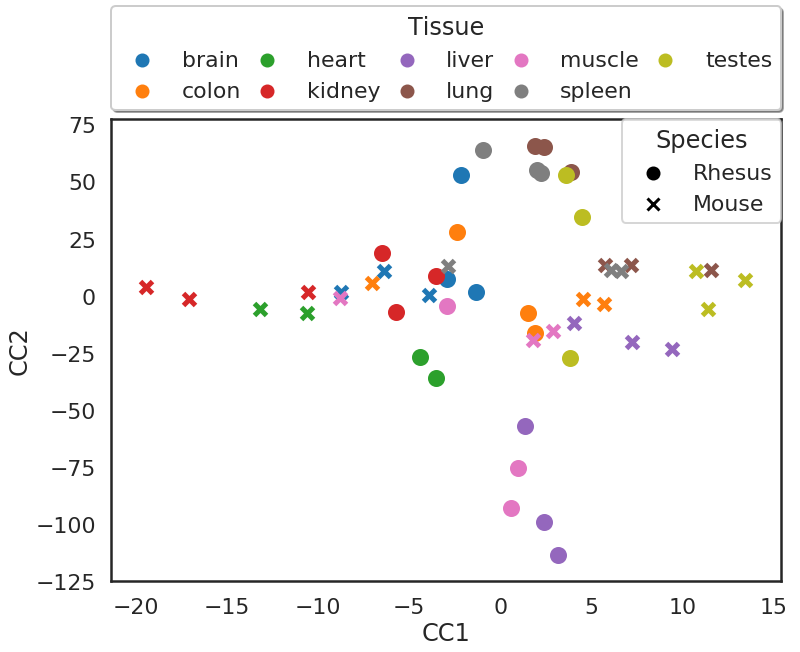

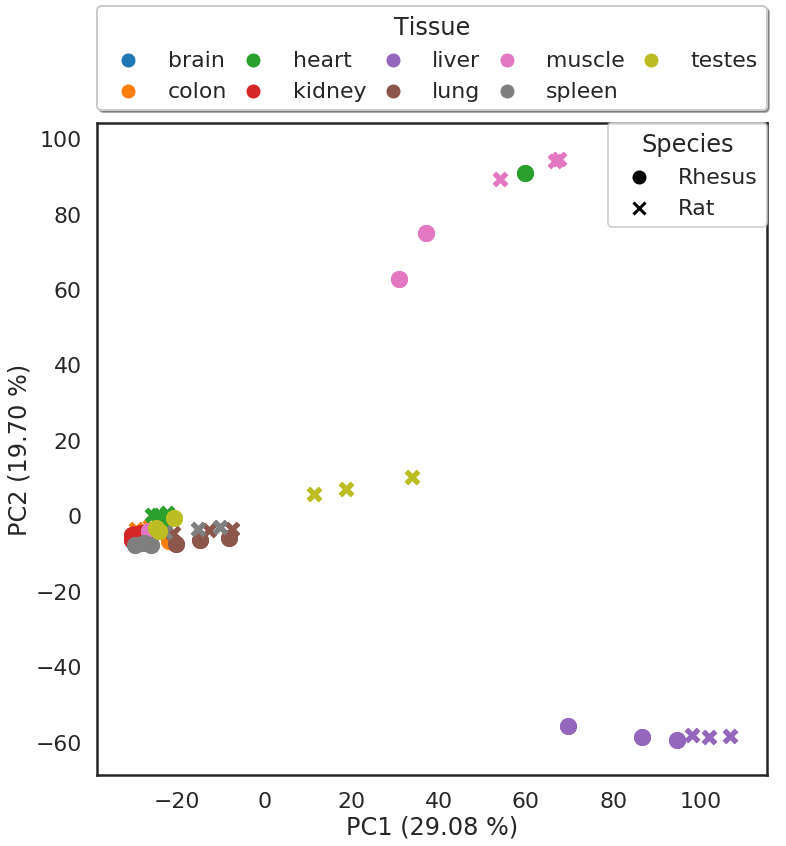

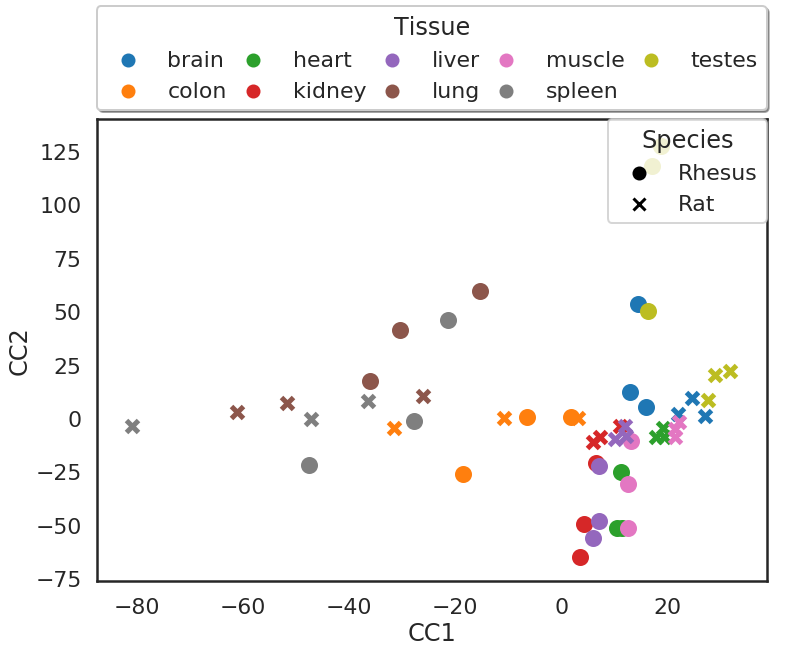

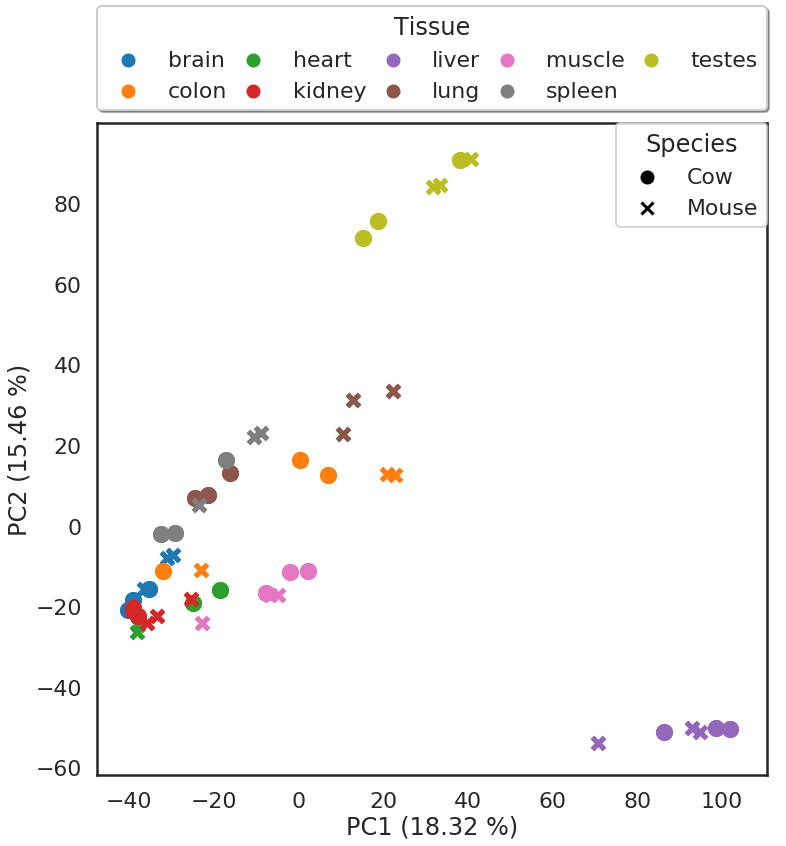

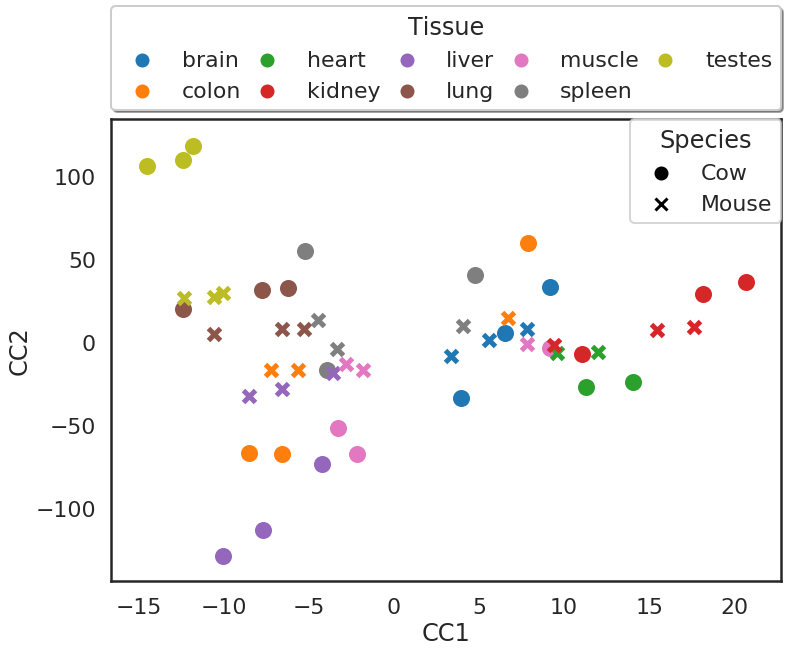

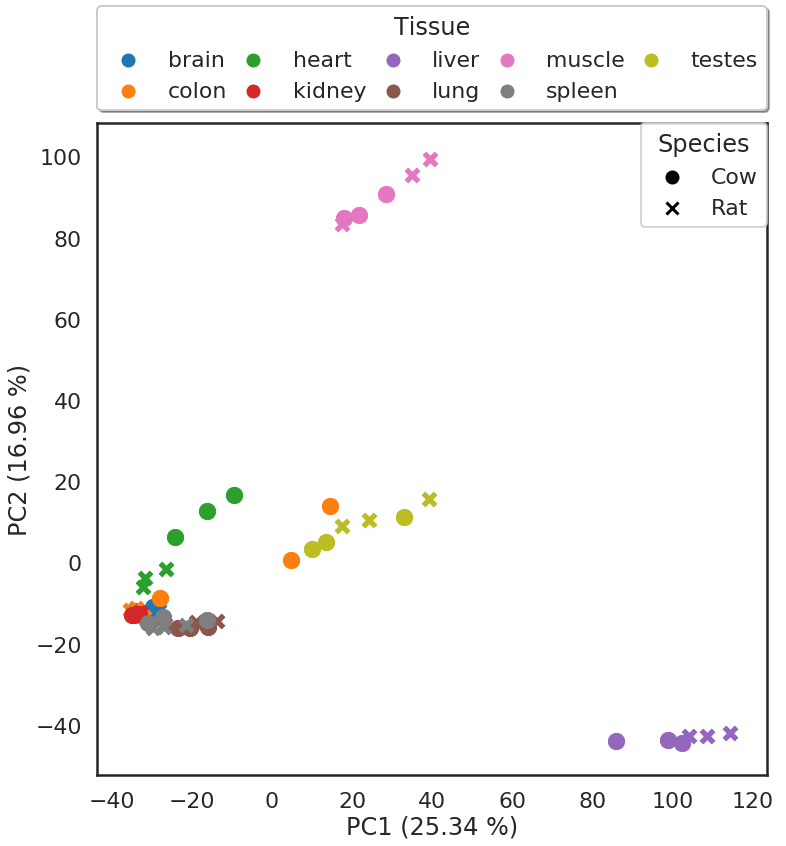

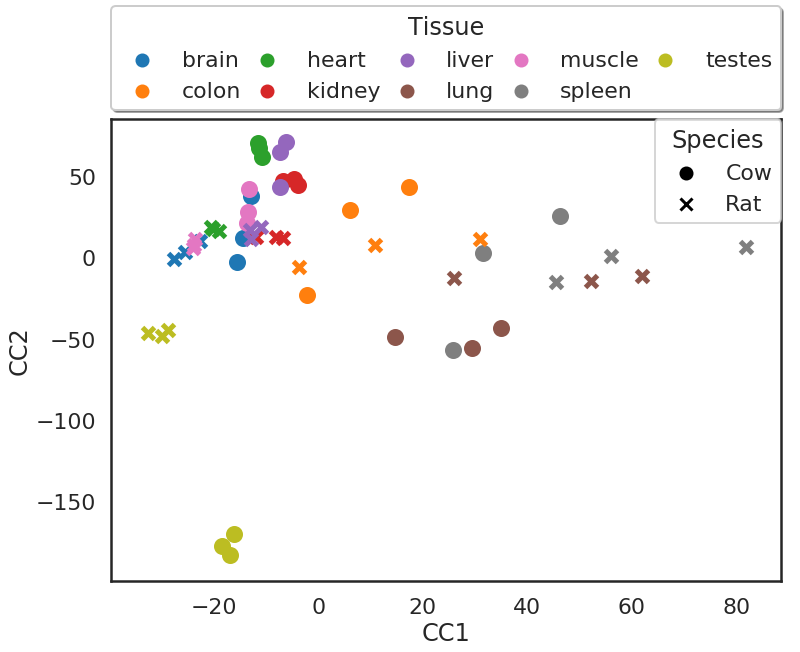

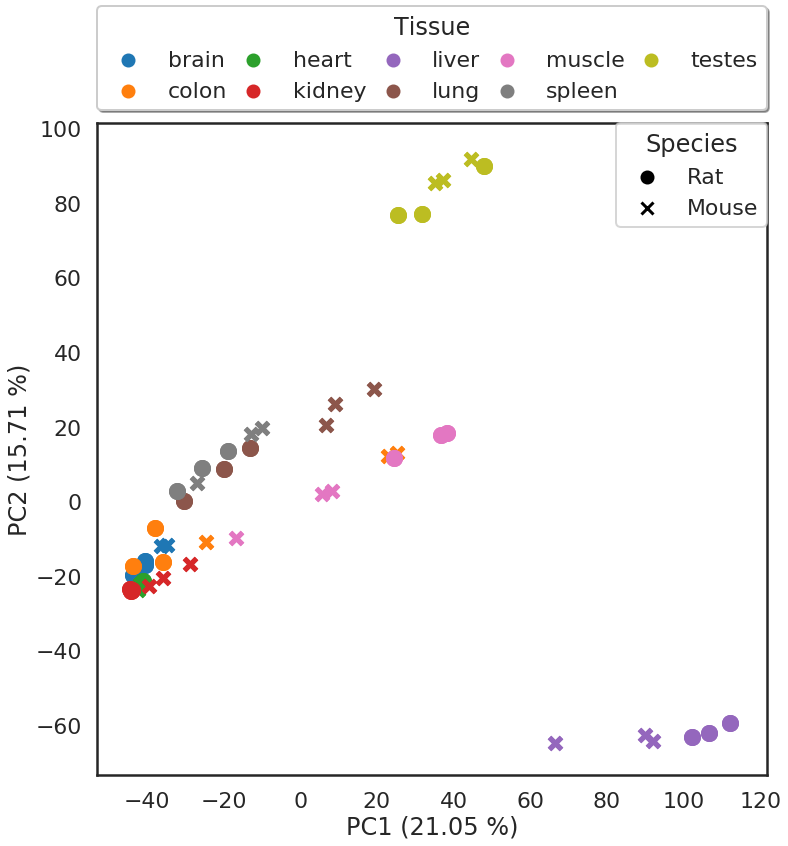

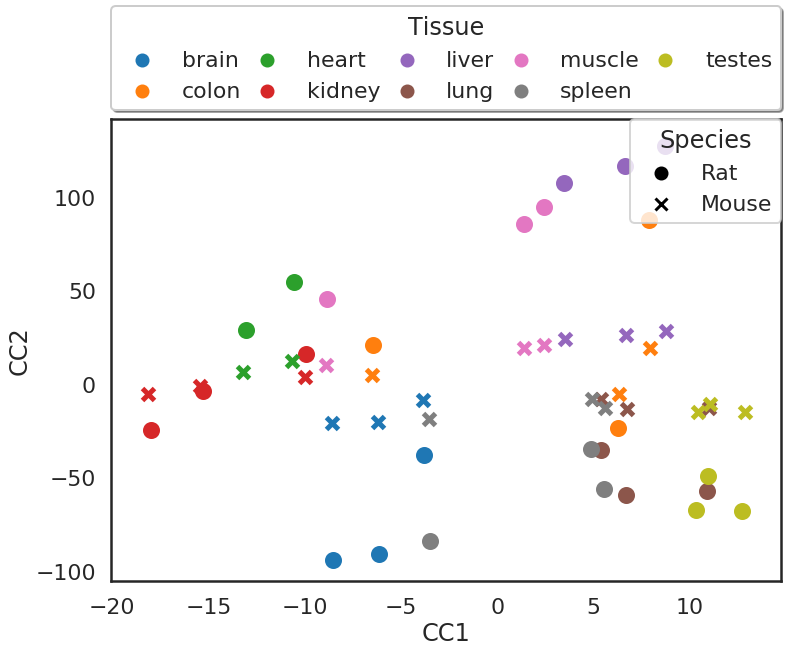

In [10]:
for species_pair, counts in pairwise_kallisto_counts_normalized.items():
    X = counts.values
    target_names = counts.index
    X_r, fig = do_PCA(X, target_names)
    species1, species2 = species_pair.split('_')
    fig.savefig('../SRP016501_plots/pca_normalized_{}_{}.pdf'.format(species, species2), 
                bbox_inches='tight')    
    X = pairwise_kallisto_counts_normalized_individual[species_pair][species1]
    Y = pairwise_kallisto_counts_normalized_individual[species_pair][species2] 
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_normalized_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    
    X = X_r[:X.shape[0],]
    Y = X_r[X.shape[0]:,]
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_on_pca_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    
    plt.close()


In [8]:
species = ["bos_taurus"
           "rattus_norvegicus",
           "pongo_abelii",
           "monodelphis_domestica",
           "macaca_mulatta",
           "pan_troglodytes",
           "mus_musculus",
           "homo_sapiens",
           "gallus_gallus",
           "ornithorhynchus_anatinus",
           "gorilla_gorilla",
           "pan_paniscus"]
species_short_form = []
for sp in species:                      
    short_form = sp[0]+sp.split('_')[-1]
    species_short_form.append(short_form)
    

## Load All orthologous genes at once

In [9]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP016501-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('_')[1] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)
srp = 'SRP016501'
ortho_pairwise = {}
all_orthologs = pd.DataFrame()
for f in ['../ortholog_tsv/mmusculus_{}.tsv'.format(x) for x in map(lambda s: species_short(s), species_wise_tissues.keys())]:
    if 'mmusculus_mmusculus' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    df = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')
    df = df[df['{}_homolog_orthology_type'.format(second_species)]=='ortholog_one2one'].drop(columns=['{}_homolog_orthology_type'.format(second_species)])
    all_orthologs = all_orthologs.join(df, how='outer')

In [10]:
all_orthologs_filtered = all_orthologs.copy()
for species in species_wise_tissues.keys():
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    if species == 'mmusculus':
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered.index.isin(count.index)]
    else:
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].isin(count.index)]

        

In [11]:
all_species_combined_counts_df = pd.DataFrame()
specie_wise_counts = []
specie_wise_index_tracker = []
specie_wise_target_names = {}
for index, species in enumerate(['mus_musculus', 'gallus_gallus', 'macaca_mulatta', 'bos_taurus', 'rattus_norvegicus']):
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    col_key = '{}_homolog_ensembl_gene'.format(species)
    print(species)
    if index == 0:
        count = count.loc[all_orthologs_filtered.index, ]
        column_order = count.columns
        count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        all_species_combined_counts_df = count
        
    else:
        count = count.loc[all_orthologs_filtered[col_key], column_order]
        count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        count.index = all_species_combined_counts_df.index.tolist()
        #assert (count.columns == column_order).all()
        all_species_combined_counts_df = all_species_combined_counts_df.join(count, how='outer')
    
    specie_wise_counts.append(count)
    specie_wise_target_names[species] =     count.columns.tolist()
    specie_wise_index_tracker.append(count.shape[1])

mmusculus
ggallus
mmulatta
btaurus
rnorvegicus


In [12]:
specie_wise_index_tracker

[26, 26, 26, 26, 26]

In [13]:
all_species_combined_counts_df_T = all_species_combined_counts_df.T

In [14]:
all_species_combined_counts_df_normalized = normalize_df_rowwise(all_species_combined_counts_df_T)

eig_dim: 130


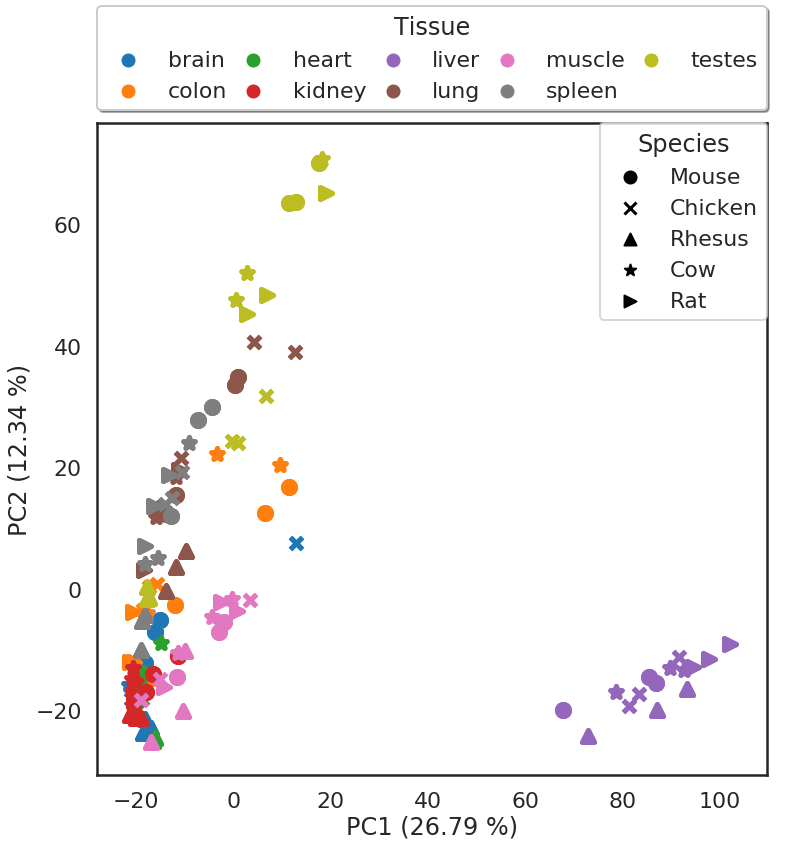

In [15]:
gcca = GCCA()
gcca.fit(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2], specie_wise_counts[3], specie_wise_counts[4])

gcca.transform(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2], specie_wise_counts[3], specie_wise_counts[4])


X = all_species_combined_counts_df_normalized.values
target_names = all_species_combined_counts_df_normalized.index
X_r, fig = do_PCA(X, target_names)
fig.savefig('../SRP016501_plots/pca_normalized_all.pdf', 
            bbox_inches='tight')    




eig_dim: 130


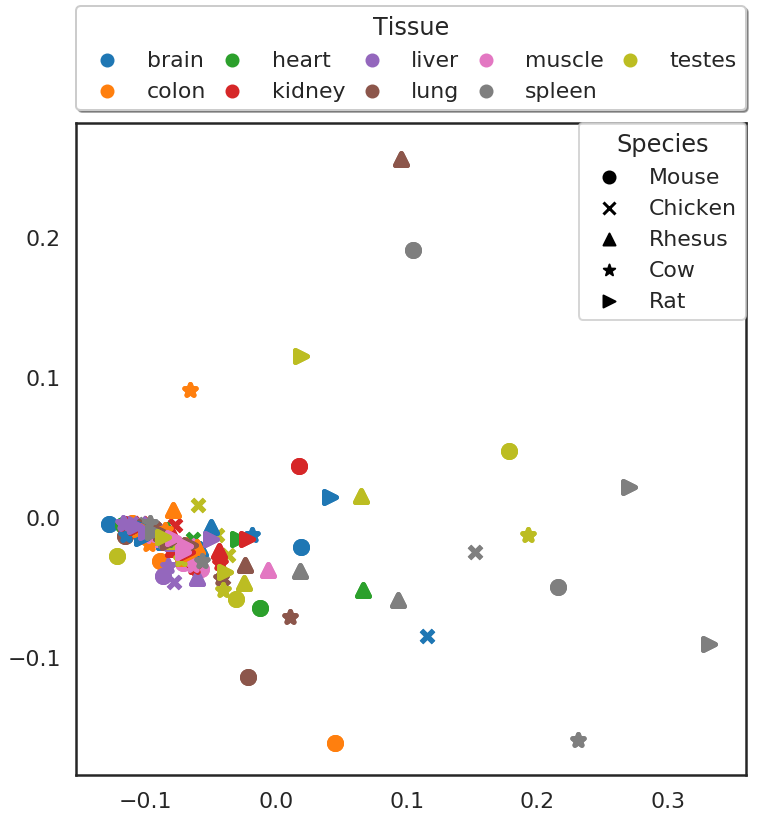

In [16]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
gcca.fit(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2], specie_wise_counts[3], specie_wise_counts[4])

gcca.transform(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2], specie_wise_counts[3], specie_wise_counts[4])

X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(['mus_musculus', 'gallus_gallus', 'macaca_mulatta', 'bos_taurus', 'rattus_norvegicus']):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species',
             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
             )# frameon=False)
ax.add_artist(leg)
fig.savefig('../SRP016501_plots/cca_normalized_all.pdf', bbox_inches='tight')

eig_dim: 125


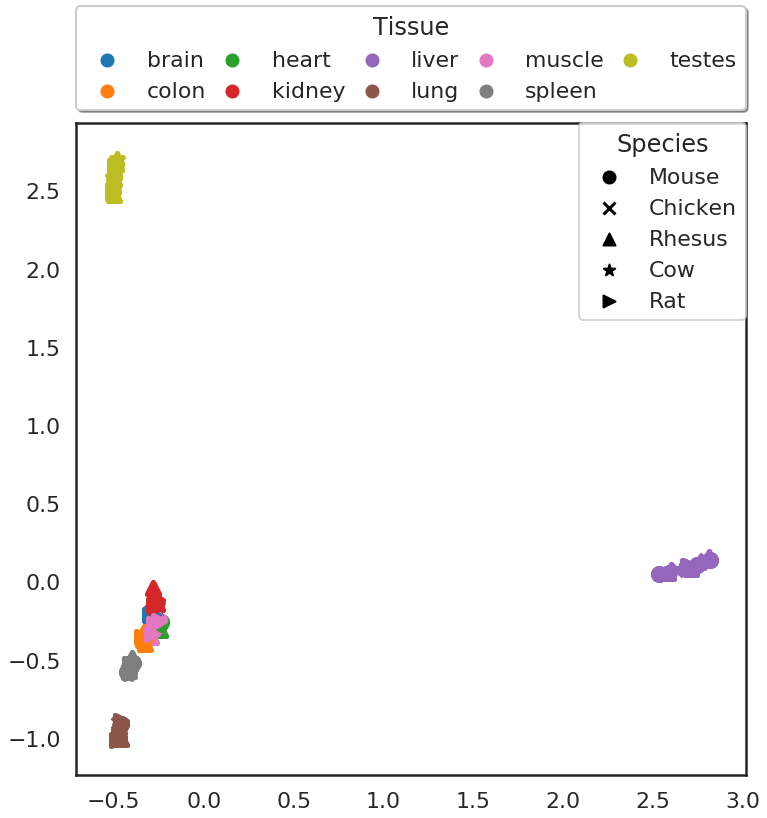

In [17]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
PCA_transformed = PCA(n_components=min(all_species_combined_counts_df_normalized.shape)).fit(all_species_combined_counts_df_normalized).transform(all_species_combined_counts_df_normalized)
a,b,c,d,e = PCA_transformed[:specie_wise_index_tracker[0],:], PCA_transformed[specie_wise_index_tracker[0]:sum(specie_wise_index_tracker[:2]), :],          PCA_transformed[sum(specie_wise_index_tracker[:2]):sum(specie_wise_index_tracker[:3]), :],          PCA_transformed[sum(specie_wise_index_tracker[:3]):sum(specie_wise_index_tracker[:4]), :],          PCA_transformed[sum(specie_wise_index_tracker[:4]):, :]
gcca.fit(a,b,c,d,e)

gcca.transform(a,b,c,d,e)
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(['mus_musculus', 'gallus_gallus', 'macaca_mulatta', 'bos_taurus', 'rattus_norvegicus']):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species',
             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0, shadow=False,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
             )# frameon=False)
ax.add_artist(leg)
fig.savefig('../SRP016501_plots/cca_on_pca_all.pdf',bbox_inches='tight')

In [19]:
SPECIES_FOR_SRP = ['mus_musculus', 'gallus_gallus',  'macaca_mulatta', 
                   'bos_taurus', 'rattus_norvegicus']

# HO-SVD

In [23]:
from collections import OrderedDict
common_tissue_counts = OrderedDict()
common_tissue_counts_normalized = OrderedDict()
for index, species in enumerate(SPECIES_FOR_SRP):
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    col_key = '{}_homolog_ensembl_gene'.format(species)
    print(species)
    if index == 0:
        column_order = count.columns.tolist()
        count = count.loc[:, column_order]
    else:
        count = count.loc[:, column_order]


    count = count.loc[:, column_order]        
    common_tissue_counts[species] = count
    common_tissue_counts_normalized[species] = normalize_df_colwise(count)

mmusculus
ggallus
mmulatta
btaurus
rnorvegicus


In [24]:
U, sigmas, V, eigen_values = ho_SVD(common_tissue_counts_normalized.values())

In [25]:
eigen_values

array([116.96320096,  28.21611305,  18.52302345,  10.55077767,
         7.29188968,   6.63731773,   6.3408406 ,   5.74813389,
         5.02459511,   4.69200679,   4.52376453,   4.12023552,
         3.5213847 ,   3.14314903,   3.06100412,   2.63855885,
         2.52328712,   2.45378416,   2.24357167,   2.00773413,
         1.92651004,   1.72041435,   1.68060074,   1.45137314,
         1.41427324,   1.11802728])

In [26]:
sigmas[1]

array([163.34987798, 200.75953238, 192.35418621,  68.02259972,
        72.2816869 ,  84.52879155, 122.79214585,  63.48967099,
        85.17983157,  66.80385193, 114.59666995, 115.19471348,
        48.0222495 , 110.99697041, 138.62128098, 115.85321314,
       125.2090254 ,  87.27749844, 119.62528217,  88.2438202 ,
       192.64977151, 143.2686209 , 159.44501527,  94.17991799,
       303.61002796, 222.84087216])

In [27]:
sigmas[0].shape

(26,)

In [28]:
angles[0].shape

NameError: name 'angles' is not defined

In [ ]:
angles

In [29]:
common_tissue_counts_normalized.keys()

odict_keys(['mmusculus', 'ggallus', 'mmulatta', 'btaurus', 'rnorvegicus'])

In [31]:
eigen_indexes = np.where(1/eigen_values >= 0.5)
eigen_indexes = eigen_indexes[0]
eigen_indexes 

array([20, 21, 22, 23, 24, 25])

In [34]:
# For these inidexes find the top 10% 
# and bottom 10% genes in the projection
species_wise_genes = defaultdict(list)#OrderedDict()
species_wise_totalgenes = OrderedDict()
for species_index, species in enumerate(common_tissue_counts_normalized.keys()):
    if species == 'mmusculus':
        orthologous_genelist = all_orthologs_filtered.index.dropna().tolist()
    else:
        orthologous_genelist = all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].dropna().tolist()

    for eigen_index in eigen_indexes:
        projection = np.dot(U[species_index], V)[:, eigen_index]
        total_genes = len(projection)
        #n_genes_to_select = int(0.1 * total_genes)
        n_genes_to_select = int(np.floor(0.1*len(orthologous_genelist)))
        bottom10_genes = np.argsort(projection)[:n_genes_to_select]
        top10_genes = np.argsort(projection)[::-1][:n_genes_to_select]
        counts =  kallisto_counts['{}_{}'.format(srp, species)]
        bottom10_genes = counts.iloc[bottom10_genes,:].index.tolist()
        top10_genes = counts.iloc[top10_genes,:].index.tolist()
        species_wise_genes[species] += bottom10_genes + top10_genes
    species_wise_genes[species] = set(species_wise_genes[species])
    species_wise_totalgenes[species] = len(counts.index)

In [35]:
from scipy.stats import hypergeom
for species, genelist in species_wise_genes.items():
    if species == 'mmusculus':
        genelist2 = all_orthologs_filtered.index.dropna().tolist()
        intersection = len(set(genelist).intersection(genelist2))
    else:
        genelist2 = all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].dropna().tolist()
        intersection = len(set(genelist).intersection(genelist2))
    M = species_wise_totalgenes[species]
    n = len(genelist2)
    N = len(genelist)
    k = intersection
    p = hypergeom.sf(k, M, n, N)
    print(species, len(genelist), len(genelist2), intersection/len(all_orthologs_filtered.index), p)

mmusculus 4216 9362 0.22954496902371288 5.051814344420183e-294
ggallus 3933 9362 0.2621234778893399 2.468998397299439e-60
mmulatta 4304 9362 0.23873104037598802 1.1349579257963526e-33
btaurus 4055 9362 0.23221533860286264 1.0133457818105678e-34
rnorvegicus 4081 9362 0.21832941679128393 3.72110679281272e-55


In [36]:
species_wise_totalgenes[species]

23918

# Hypergeometric test

#pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
#                               for max(0, N - (M-n)) <= k <= min(n, N)
# k, M, n, N, 
# M = population size
# N = sample size
# k = number of successes in sample
# n = number of successes in population

{\displaystyle p_{X}(k)=\Pr(X=k)={\frac {{\binom {K}{k}}{\binom {N-K}{n-k}}}{\binom {N}{n}}},}
where

{\displaystyle N} N is the population size,
{\displaystyle K} K is the number of success states in the population,
{\displaystyle n} n is the number of draws (i.e. quantity drawn in each trial),
{\displaystyle k} k is the number of observed successes,

{\textstyle \textstyle {a \choose b}} {\textstyle \textstyle {a \choose b}} is a binomial coefficient.
prb = hypergeom.sf(

In [127]:
U[1][:, 7]

array([0.00052742, 0.00048399, 0.0005293 , ..., 0.00059747, 0.00057996,
       0.00059747])

SyntaxError: invalid syntax (<ipython-input-230-c44bd885072a>, line 1)

In [38]:
# For these inidexes find the top 10% 
# and bottom 10% genes in the projection
species_wise_genes = defaultdict(list)#OrderedDict()
species_wise_totalgenes = OrderedDict()
species_wise_new_counts = OrderedDict()
species_wise_new_counts_df = pd.DataFrame()
n_genes_to_select = 2000
minimum_common_n_genes = 9999999
species_wise_genes[species]
for species_index, species in enumerate(common_tissue_counts_normalized.keys()):
    if species == 'mmusculus':
        orthologous_genelist = all_orthologs_filtered.index.dropna().tolist()
    else:
        orthologous_genelist = all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].dropna().tolist()

    for eigen_index in eigen_indexes:
        projection = np.dot(U[species_index], V)[:, eigen_index]
        total_genes = len(projection)
        bottom10_genes = np.argsort(projection)[:n_genes_to_select]
        top10_genes = np.argsort(projection)[::-1][:n_genes_to_select]
        counts =  kallisto_counts['{}_{}'.format(srp, species)]
        bottom10_genes = counts.iloc[bottom10_genes,:].index.tolist()
        top10_genes = counts.iloc[top10_genes,:].index.tolist()
        species_wise_genes[species] += bottom10_genes + top10_genes
    species_wise_genes[species] = set(species_wise_genes[species])
    species_wise_totalgenes[species] = len(counts.index)
    count = counts.loc[species_wise_genes[species], column_order]
    count.columns = ['{}_{}'.format(species, x) for x in count.columns]
    species_wise_new_counts[species] = count
    if count.shape[0] < minimum_common_n_genes:
        minimum_common_n_genes= count.shape[0]

In [39]:
species_wise_new_counts_df = pd.DataFrame()
for species_index, species in enumerate(common_tissue_counts_normalized.keys()):
    count  = species_wise_new_counts[species].iloc[:minimum_common_n_genes,:]
    
    if species_index == 0:
        index_replacer = count.index
        species_wise_new_counts_df = count.T
    else:
        count.index = index_replacer
    
    species_wise_new_counts_df = pd.concat([species_wise_new_counts_df, count.T])
    

In [40]:
species_wise_new_counts_df

,ENSMUSG00000050953,ENSMUSG00000029162,ENSMUSG00000075225,ENSMUSG00000025911,ENSMUSG00000040866,ENSMUSG00000038141,ENSMUSG00000020721,ENSMUSG00000037973,ENSMUSG00000027455,ENSMUSG00000029203,...,ENSMUSG00000114547,ENSMUSG00000028957,ENSMUSG00000022314,ENSMUSG00000042606,ENSMUSG00000091264,ENSMUSG00000035890,ENSMUSG00000022193,ENSMUSG00000031628,ENSMUSG00000023169,ENSMUSG00000024726
mmusculus_a_brain,18000.038600,482.99990,122.884389,819.000130,19.0000,13399.590000,6000.99654,112.0000,6078.038300,8989.409105,...,975.03700,3974.04600,9935.99906,1768.759600,18919.800000,2054.8270,2115.30700,1009.999800,20806.012700,741.000
mmusculus_a_colon,3023.376240,15520.99000,44.348760,54.000020,3.0000,9025.931000,5668.00325,42.0000,5210.002300,5786.962700,...,1442.63000,3531.50230,13489.98695,1519.360800,1268.000000,2395.9920,2568.87000,18924.976100,6128.555200,1134.810
mmusculus_a_heart,9733.877320,305.99998,63.697800,1280.000800,0.0000,1121.115900,483.99972,0.0000,2107.001870,1446.272200,...,190.18400,1555.63940,1771.00000,203.999706,806.000000,189.9997,1284.03040,264.000065,530.263200,1428.800
mmusculus_a_kidney,845.771000,42789.02100,516.764690,27586.949900,1.0000,1225.239100,3726.00384,0.0000,10976.172000,6316.423700,...,655.31500,4827.75100,17575.03240,799.000600,1491.890000,3038.9900,5470.04140,1397.997100,559.730320,1733.500
mmusculus_a_liver,341.856300,23830.95600,899.337260,5645.999500,0.0000,433.712600,1255.99567,0.0000,4652.671430,4455.161480,...,385.52400,2766.72680,3618.00115,258.000250,2397.000000,1561.0002,3275.20200,2404.998600,309.108000,1505.240
mmusculus_a_lung,2393.694700,415.00027,1260.094320,327.000320,2.0000,2205.943400,1636.00104,857.0000,2074.999880,1919.547000,...,558.44200,3898.04110,4211.99634,440.834040,864.000000,425.0004,755.52950,696.999700,1528.704700,823.759
mmusculus_a_skm,1486.855540,1233.00000,287.178700,2483.002130,4.0000,1634.473800,2891.99685,0.0000,5503.685580,5002.175200,...,167.06900,3975.18880,5141.00496,564.783600,7380.000000,3197.9986,3204.79900,295.999700,218.195120,23007.800
mmusculus_a_spleen,4240.374600,1395.00000,282.289950,79.999980,1.0000,5076.880000,8800.00026,2.0000,6728.155800,6949.322120,...,1065.47000,2416.04400,12649.97680,2471.996300,1678.400000,2911.9710,3104.54900,3036.001740,15902.968900,1914.540
mmusculus_a_testes,4712.535600,236.00010,982.244800,387.000230,25612.0432,3178.345000,8809.00000,4.0000,2912.584340,19326.101270,...,418.20000,1308.55770,9431.99500,11849.343600,6552.950000,31779.9600,2316.03910,212.000230,2453.127900,3227.210
mmusculus_b_brain,15538.935570,822.00000,290.165630,1364.000230,45.0000,27266.862000,7482.00226,125.9995,9334.733700,11382.873280,...,320.99100,6298.43600,10789.99850,3804.998800,21927.000000,4782.9960,5882.21840,1146.000000,18703.264700,712.157


In [41]:
species_wise_new_counts_df_normalized = normalize_df_rowwise(species_wise_new_counts_df)

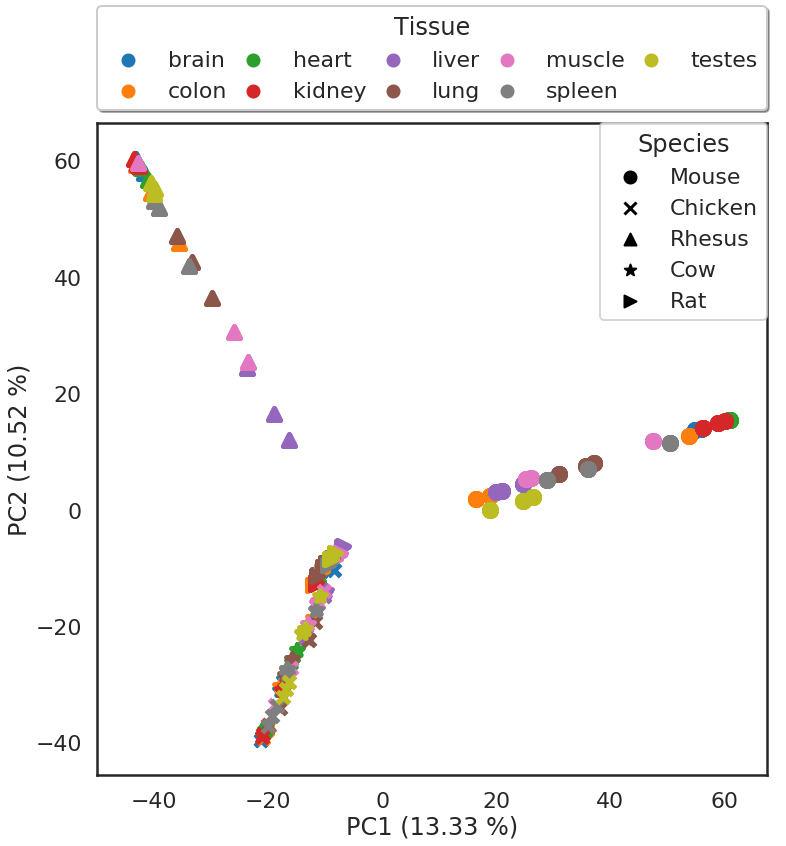

In [42]:
X = species_wise_new_counts_df_normalized.values
target_names = species_wise_new_counts_df_normalized.index
X_r, fig = do_PCA(X, target_names)


In [43]:
specie_wise_index_tracker

[26, 26, 26, 26, 26]

eig_dim: 125


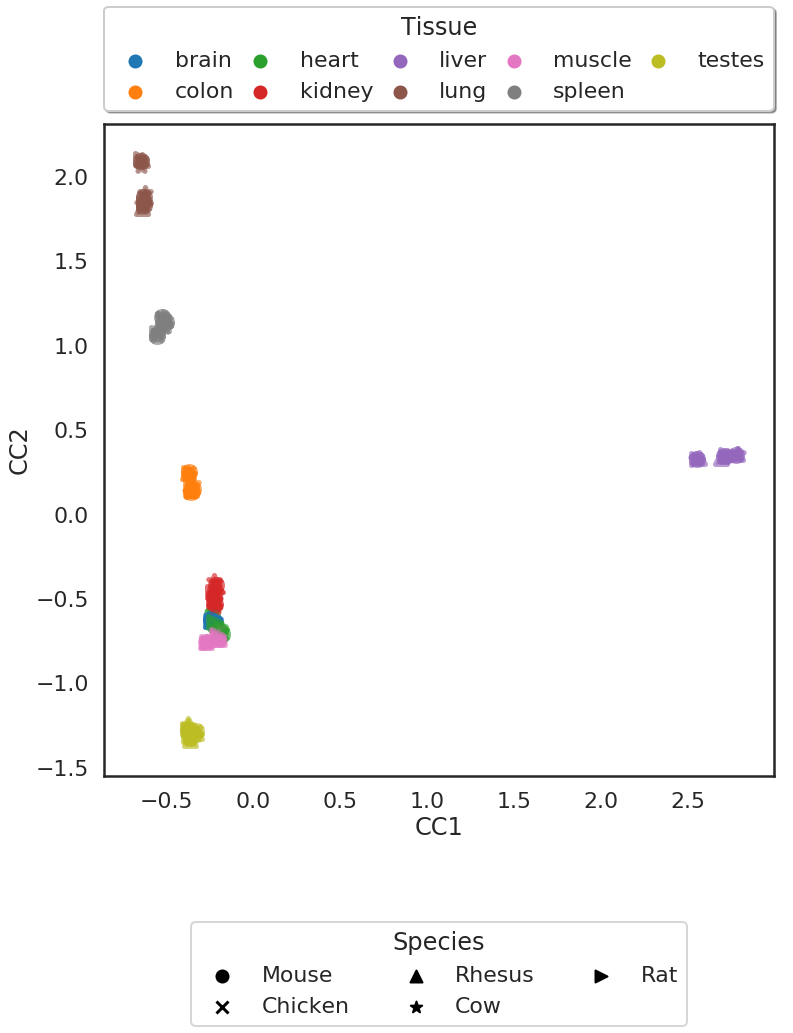

In [44]:
fig , ax  = plt.subplots(figsize=(12, 12))

gcca = GCCA()
PCA_transformed = PCA(n_components=min(species_wise_new_counts_df_normalized.shape)).fit(species_wise_new_counts_df_normalized).transform(species_wise_new_counts_df_normalized)

a = PCA_transformed[:specie_wise_index_tracker[0],:]
b = PCA_transformed[specie_wise_index_tracker[0]:sum(specie_wise_index_tracker[:2]), :]
c = PCA_transformed[sum(specie_wise_index_tracker[:2]):sum(specie_wise_index_tracker[:3]), :]
d = PCA_transformed[sum(specie_wise_index_tracker[:3]):sum(specie_wise_index_tracker[:4]), :]
e = PCA_transformed[sum(specie_wise_index_tracker[:4]):sum(specie_wise_index_tracker[:5]), :]

gcca.fit(a,b,c,d,e)
gcca.transform(a,b,c,d,e)
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(SPECIES_FOR_SRP):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = species_wise_new_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0, shadow=False,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
#            )# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species', ncol=3, 
             bbox_to_anchor=(0.5, -0.4), loc='lower center',)
ax.add_artist(leg)
ax.set_xlabel('CC1')
ax.set_ylabel('CC2')
fig.savefig('../SRP016501_plots/cca_on_pca_shortlisted_genes.pdf',
            bbox_inches='tight')